In [52]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.covariance import LedoitWolf
import matplotlib.pyplot as plt


In [53]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN','META','NVDA']
tickers_2 = ['SPY','AGG','GLD','TLT','VNQ']
tickers_3 = ['SPY','EWJ','INDA','EWU','EZA'] # 5 country ETFs, non-overlapping
tickers_4 = ['GLD','NVDA']
start_date = '2019-01-01'
end_date = '2025-06-30'

In [54]:
def fetch_data(tickers,start_date,end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Close']
    print(data.head())
    return data

In [55]:
data = fetch_data(tickers_4,start_date,end_date)

/var/folders/v6/hggmpf4134v8nppmrh142shw0000gn/T/ipykernel_2219/2377045159.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  2 of 2 completed

Ticker             GLD      NVDA
Date                            
2019-01-02  121.330002  3.377354
2019-01-03  122.430000  3.173304
2019-01-04  121.440002  3.376611
2019-01-07  121.860001  3.555370
2019-01-08  121.529999  3.466859


In [56]:
def calculate_returns(prices, method='log'):
    if method == 'simple':
        returns = prices.pct_change().dropna()
    elif method == 'log':
        returns = np.log(prices / prices.shift(1)).dropna()
    
    return returns

In [57]:
log_returns = calculate_returns(data, method='log')
print(log_returns.head())

Ticker           GLD      NVDA
Date                          
2019-01-03  0.009025 -0.062319
2019-01-04 -0.008119  0.062099
2019-01-07  0.003453  0.051587
2019-01-08 -0.002712 -0.025210
2019-01-09  0.006398  0.019476


In [58]:
def get_ledoit_wolf_covariance(returns):
    lw = LedoitWolf()
    lw.fit(returns)
    
    cov_lw = lw.covariance_ * 252
    
    cov_df = pd.DataFrame(
        cov_lw, 
        index=returns.columns, 
        columns=returns.columns
    )
    return cov_df

In [59]:
lw_cov = get_ledoit_wolf_covariance(log_returns)
print(lw_cov)
print(log_returns.cov()*252)

Ticker       GLD      NVDA
Ticker                    
GLD     0.024899  0.006340
NVDA    0.006340  0.274792
Ticker       GLD      NVDA
Ticker                    
GLD     0.023716  0.006405
NVDA    0.006405  0.276158


In [60]:
def inverse_vol_weights(cov):
        vol = np.sqrt(np.diag(cov))
        inv_vol = 1 / vol
        
        weights = inv_vol / inv_vol.sum()
        
        return pd.Series(weights, index=cov.columns, name="IVP")

In [61]:
ivp_weights = inverse_vol_weights(lw_cov)
print(ivp_weights)

Ticker
GLD     0.768632
NVDA    0.231368
Name: IVP, dtype: float64


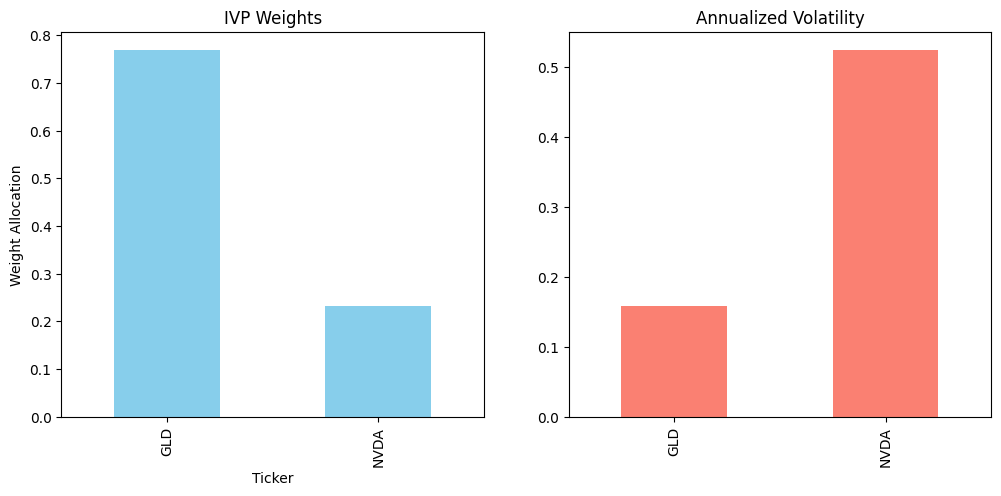

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ivp_weights.plot(kind='bar', ax=ax[0], title='IVP Weights', color='skyblue')
ax[0].set_ylabel('Weight Allocation')

vol = np.sqrt(np.diag(lw_cov))
pd.Series(vol, index=tickers_4).plot(kind='bar', ax=ax[1], title='Annualized Volatility', color='salmon')

plt.show()

In [63]:
tickers_test = ['SPY', 'IVV', 'VOO', 'TLT'] # 3 ETFS on S&P 500 + 1 Treasury
data_test = fetch_data(tickers_test,start_date,end_date) 
returns_test = calculate_returns(data_test)
covar_test = get_ledoit_wolf_covariance(returns_test)
ivp_weights_test = inverse_vol_weights(covar_test)

/var/folders/v6/hggmpf4134v8nppmrh142shw0000gn/T/ipykernel_2219/2377045159.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)['Close']
[*********************100%***********************]  4 of 4 completed

Ticker             IVV         SPY         TLT         VOO
Date                                                      
2019-01-02  225.827454  225.660172  101.310394  206.556625
2019-01-03  220.184402  220.275299  102.463234  201.625961
2019-01-04  227.926712  227.653580  101.277222  208.281021
2019-01-07  229.460846  229.448547  100.978630  209.843719
2019-01-08  231.721603  231.604309  100.713226  211.882431


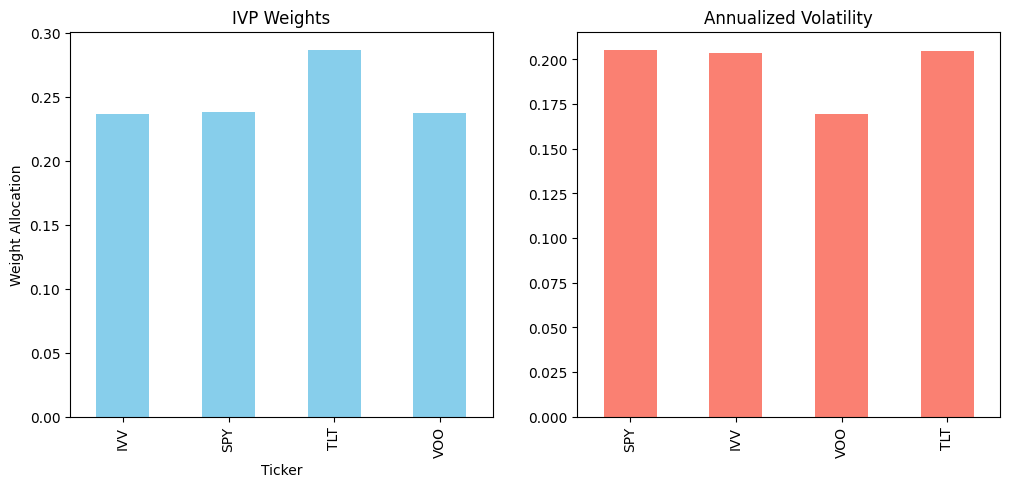

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ivp_weights_test.plot(kind='bar', ax=ax[0], title='IVP Weights', color='skyblue')
ax[0].set_ylabel('Weight Allocation')

vol = np.sqrt(np.diag(covar_test))
pd.Series(vol, index=tickers_test).plot(kind='bar', ax=ax[1], title='Annualized Volatility', color='salmon')

plt.show()

In [65]:
def calculate_risk_contribution(weights, cov_matrix):
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    
    mcr = np.dot(cov_matrix, weights) / port_vol
    
    rc = weights * mcr
    
    rc_percent = rc / port_vol
    
    return pd.Series(rc_percent, index=weights.index)

In [66]:
rc_ivp = calculate_risk_contribution(ivp_weights, lw_cov)
equity_risk = rc_ivp['NVDA']
bond_risk = rc_ivp['GLD']
print(f"Total Risk from Equities: {equity_risk:.2%}")
print(f"Total Risk from Bonds:    {bond_risk:.2%}")

Total Risk from Equities: 50.00%
Total Risk from Bonds:    50.00%


In [67]:
rc_ivp = calculate_risk_contribution(ivp_weights_test, covar_test)
equity_risk = rc_ivp['SPY'] + rc_ivp['IVV'] + rc_ivp['VOO']
bond_risk = rc_ivp['TLT']
print(f"Total Risk from Equities: {equity_risk:.2%}")
print(f"Total Risk from Bonds:    {bond_risk:.2%}")

Total Risk from Equities: 93.84%
Total Risk from Bonds:    6.16%
